# Load Packages

In [0]:
%%capture
!pip install "tensorflow>=2.0.0"
!pip install git+https://github.com/kmedian/keras-layernorm-rnn.git
!pip install lagmat

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from keras_layernorm_rnn import (
    LayernormSimpleRNN, LayernormLSTM1, LayernormLSTM2, LayernormLSTM3)
from lagmat import lagmat

import matplotlib.pyplot as plt
%matplotlib inline

# Generate Fake Dataset

In [0]:
n_obs = 2000    
delta = 0.05 
sigma = 0.5

t = np.arange(0, n_obs)
dat = np.cos(delta * t) + sigma * np.random.randn(n_obs)

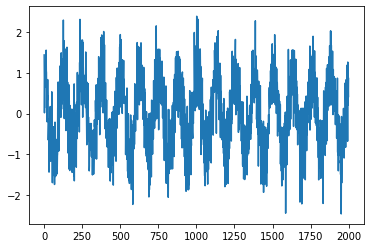

In [4]:
plt.plot(t, dat);

In [0]:
n_inp_steps = int(1. / delta)
n_out_steps = n_inp_steps // 2

mat = lagmat(dat, lags=range(n_inp_steps + n_out_steps))

In [6]:
print(mat[:6, :6])

[[1.44107411        nan        nan        nan        nan        nan]
 [0.94623494 1.44107411        nan        nan        nan        nan]
 [0.01915727 0.94623494 1.44107411        nan        nan        nan]
 [0.68660405 0.01915727 0.94623494 1.44107411        nan        nan]
 [0.94761242 0.68660405 0.01915727 0.94623494 1.44107411        nan]
 [0.73627339 0.94761242 0.68660405 0.01915727 0.94623494 1.44107411]]


In [0]:
# chop the nan away
idx_start = n_inp_steps + n_out_steps - 1
mat = mat[idx_start:, :]

In [0]:
# divide into y, X
X, y = mat[:, :n_inp_steps], mat[:, n_inp_steps:]

In [0]:
# data splitting
n_train = int(n_obs * 0.8)
X_train, X_valid = X[:n_train, :], X[n_train:, :]
Y_train, Y_valid = y[:n_train, :], y[n_train:, :]

In [0]:
# reshape input sequences for Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
# reshape output sequences for Keras
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
Y_valid = np.reshape(Y_valid, (Y_valid.shape[0], Y_valid.shape[1], 1))

In [11]:
X_valid.shape, Y_valid.shape

((371, 20, 1), (371, 10, 1))

# Modelling

# model1 - SimpleRNN

In [0]:
n_features = 1   # Input sequence is a simple univariate time series
n_targets = 1  # Output sequence is a simple univariate time series
n_rnn = 8
n_relu = 3

model1 = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=True,  # Many-to-Many
    ),
    # chop output sequence
    tf.keras.layers.Lambda(lambda x: x[:, -n_out_steps:, :]), 
    # process output sequence step-by-step
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

opt_args = {
    'loss': 'mean_squared_error',
    'optimizer': tf.keras.optimizers.Adam(1e-4)
}

model1.compile(**opt_args)

## model2 - LayernormSimpleRNN

In [0]:
model2 = tf.keras.Sequential([
    LayernormSimpleRNN(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=True,  # Many-to-Many
    ),
    # chop output sequence
    tf.keras.layers.Lambda(lambda x: x[:, -n_out_steps:, :]), 
    # process output sequence step-by-step
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model2.compile(**opt_args)

## model 3 - LSTM

In [0]:
model3 = tf.keras.Sequential([
    tf.keras.layers.LSTM(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=True,  # Many-to-Many
    ),
    # chop output sequence
    tf.keras.layers.Lambda(lambda x: x[:, -n_out_steps:, :]), 
    # process output sequence step-by-step
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model3.compile(**opt_args)

## model4-6 - LayernormLSTM1-3

In [0]:
model4 = tf.keras.Sequential([
    LayernormLSTM1(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=True,  # Many-to-Many
    ),
    # chop output sequence
    tf.keras.layers.Lambda(lambda x: x[:, -n_out_steps:, :]), 
    # process output sequence step-by-step
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model4.compile(**opt_args)

In [0]:
model5 = tf.keras.Sequential([
    LayernormLSTM2(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=True,  # Many-to-Many
    ),
    # chop output sequence
    tf.keras.layers.Lambda(lambda x: x[:, -n_out_steps:, :]), 
    # process output sequence step-by-step
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model5.compile(**opt_args)

In [0]:
model6 = tf.keras.Sequential([
    LayernormLSTM3(
        units=n_rnn,
        input_shape=(n_inp_steps, n_features),
        return_sequences=True,  # Many-to-Many
    ),
    # chop output sequence
    tf.keras.layers.Lambda(lambda x: x[:, -n_out_steps:, :]), 
    # process output sequence step-by-step
    tf.keras.layers.Dense(n_relu, activation='relu'),  # sparse activity
    tf.keras.layers.Dense(n_targets, activation='linear'),
])

model6.compile(**opt_args)

# Training

In [0]:
train_args = {
    'epochs': 50,
    'batch_size': 16, 
    'steps_per_epoch': n_train // 16,
    'validation_data': (X_valid, Y_valid),
    'verbose': 0
}

In [19]:
%%time
history1 = model1.fit(X_train, Y_train, **train_args)

CPU times: user 1min 13s, sys: 4.9 s, total: 1min 17s
Wall time: 51 s


In [20]:
%%time
history2 = model2.fit(X_train, Y_train, **train_args)

CPU times: user 1min 39s, sys: 4.78 s, total: 1min 43s
Wall time: 1min 15s


In [21]:
%%time
history3 = model3.fit(X_train, Y_train, **train_args)

CPU times: user 25.5 s, sys: 2.04 s, total: 27.5 s
Wall time: 23.8 s


In [22]:
%%time
history4 = model4.fit(X_train, Y_train, **train_args)

CPU times: user 4min 20s, sys: 7.98 s, total: 4min 28s
Wall time: 3min 45s


In [23]:
%%time
history5 = model5.fit(X_train, Y_train, **train_args)

CPU times: user 3min 50s, sys: 6.66 s, total: 3min 56s
Wall time: 3min 16s


In [24]:
%%time
history6 = model6.fit(X_train, Y_train, **train_args)

CPU times: user 4min 15s, sys: 6.9 s, total: 4min 22s
Wall time: 3min 43s


# Check Gamma Weights

In [25]:
for arr in model4.layers[0].cell.get_weights()[3:]:
    print(np.round(arr, 3))

[0.905 1.035 0.903 0.964 1.009 1.033 1.053 0.993]
[1.079 1.036 1.027 0.998 0.94  0.904 0.973 1.159]
[1.122 1.023 1.019 1.003 0.959 1.058 1.131 1.057]
[0.963 0.892 0.95  0.932 0.944 0.94  0.954 1.148]


In [26]:
for arr in model5.layers[0].cell.get_weights()[3:]:
    print(np.round(arr, 3))

[0.947 1.083 0.94  0.935 0.996 0.955 1.045 0.853]
[0.978 1.046 0.862 0.993 1.011 0.946 1.031 0.991]
[1.026 0.901 1.046 1.009 1.009 0.927 0.985 1.218]
[0.939 0.934 1.004 0.967 1.181 0.922 0.959 1.141]


In [27]:
for arr in model6.layers[0].cell.get_weights()[12:]:
    print(np.round(arr, 3))

[1.031 1.056 1.098 0.927 1.039 1.113 1.015 1.021]
[1.012 1.083 1.023 1.014 1.095 0.882 0.968 1.115]
[1.125 1.018 0.985 1.023 0.977 0.903 1.07  1.105]
[1.011 0.892 1.005 0.904 0.988 0.941 1.035 1.076]


# Compare

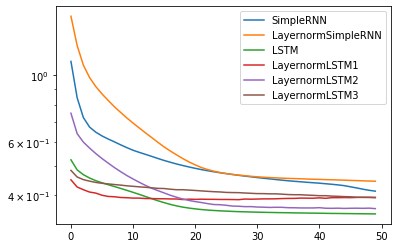

In [28]:
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_loss'])
plt.plot(history6.history['val_loss'])
plt.legend(["SimpleRNN", "LayernormSimpleRNN", "LSTM",
            "LayernormLSTM1", "LayernormLSTM2", "LayernormLSTM3"])
plt.yscale("log")
plt.show()